# Neural Networks with PyTorch
This neural network will be able to recognize handwritten digits. We will use the MNIST dataset to train the neural network. The MNIST dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 0 to 9.

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Split the dataset into training and test datasets
train_data = datasets.MNIST(
    root= 'data',
    train = True,
    transform= ToTensor(),
    download= True
)

test_data = datasets.MNIST(
    root= 'data',
    train = False,
    transform= ToTensor(),
    download= True
)

In [3]:
train_data       

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
train_data.targets  

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,   
                        batch_size= 100,  
                        shuffle= True,
                        num_workers= 1), 
    'test': DataLoader(test_data, 
                       batch_size= 100, 
                       shuffle= True,
                       num_workers=1)
}

In [9]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2e5d2193140>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2e5d1e199a0>}

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        """CNN Structure"""
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # First layer
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # Flatten the data
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training= self.training) # Dropout triggers only during training not evaluation
        x = self.fc2(x) 
        
        return F.log_softmax(x)
        
        
        
        
        

In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward() # Backpropagation
        optimizer.step() # Update the weights
        
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders['train'].dataset),
                100. * batch_idx / len(loaders['train']), loss.item()))
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() # Need to shape the target as the prediction
    
    test_loss /= len(loaders['test'].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders['test'].dataset),
        100. * correct / len(loaders['test'].dataset)))
            
        

In [12]:
for epoch in range(1, 11):
    train(epoch)
    test()

C:\Users\patri\AppData\Local\Temp\ipykernel_22348\1159085038.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309020
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.185569
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.787831
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.074570
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.942187
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.713482
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.696955
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.737601
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.712487
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.398219
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.617146
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.480646
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.493979
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.468947
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.563268
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.363853
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.431642
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.246039
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.537362
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.473805
Train Epoch

In [13]:
device # Check if the model is running on GPU

device(type='cpu')

The prediction is: 4


C:\Users\patri\AppData\Local\Temp\ipykernel_22348\1159085038.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


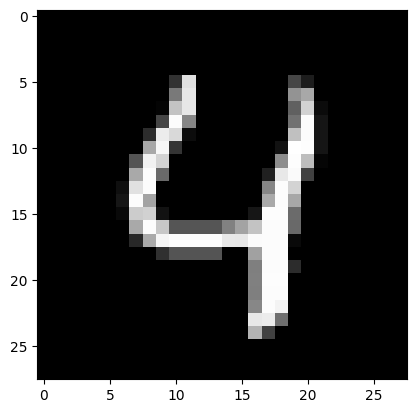

In [14]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[4]

data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()

print(f'The prediction is: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()